### <font color='blue'> In this notebook, we want to understand the cost of going from the 9*8D projected latent representation to a PNG image with its [0,255] resolution. </font>
What are the range of values in the latent vectors that we can clip to in order to normalize values for NN learning? 

In [1]:

%pwd
%cd /app

import dac
from audiotools import AudioSignal

import torch

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

import math

/app


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory/1e9
#torch.cuda.get_device_properties(1).total_memory/1e9
device = torch.device('cuda') # if the docker was started with --gpus all, then can choose here.
device

torch.cuda.device_count()
print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
#print(f'memeory on cuda 1 is  { torch.cuda.get_device_properties(1).total_memory/1e9}')
device = torch.device("cuda") # if the docker was started with --gpus all, then can choose here.
#device = torch.device('cpu') # if the docker was started with --gpus all, then can choose here
device


memeory on cuda 0 is  25.216745472


device(type='cuda')

In [4]:
model_path = dac.utils.download(model_type="44khz") 

### This model doesn't sound as good - because it was trained on different data???
# model_path = "/scratch/codecs/codec.pth" # /the default model from vampnet!

model = dac.DAC.load(model_path)

In [5]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8500
__Number CUDA Devices: 2
__CUDA Device Name: NVIDIA GeForce RTX 3090
__CUDA Device Total Memory [GB]: 25.216745472


In [6]:
model.to(device); #wanna see the model? remove the semicolon
model.eval(); 

In [7]:
dataroot="dacdevdata" 
!ls 

Dockerfile	    assets	dacdevdata.zip		       scripts
LICENSE		    conf	descript_audio_codec.egg-info  setup.py
README.md	    dac		notebooks		       tests
README_Descript.md  dacdevdata	requirements.txt


In [8]:
datadir=dataroot+"/44kHz/N4/PisWinAppBee_sparse_recon"

N_QUANTIZERS = 4  ## SEEMS TO HAVE NO EFFECT - I guess because it is a property of the pretrained model?

snd2_wav ='/DSApplause--numClappers_exp-00.50.wav' 
#snd2_wav='/DSPistons--rate_exp-00.50.wav'
#snd2_wav = '/DSBugs--busybodyFreqFactor-00.50.wav'
#snd2_wav ='/DSWind--strength-00.50.wav'

CORTADOFACTURA=1  #cut the wavefile lengths by this amount before loading so we don't overrun GPU memory

#1) LOAD A SOUND

snd2 = AudioSignal(datadir + snd2_wav) # 2-second sound at 16kHz
snd2 = snd2[0,0,: int(snd2.shape[2]/CORTADOFACTURA)] # cortado, otherwise the computation will bust memory

snd2.to(model.device)
snd2_x = model.preprocess(snd2.audio_data, snd2.sample_rate)
with torch.no_grad():
    snd2_z, snd2_codes, snd2_latents, _a, _b = model.encode(snd2_x, N_QUANTIZERS) # model.encode(snd2_x, 4)

In [9]:

print(f'snd2_z shape is: {snd2_z.shape}')
print(f'snd2_codes shape is: {snd2_codes.shape}')
print(f'snd2_latents shape is: {snd2_latents.shape}')
print(f'snd2_codes at t=40 are: {snd2_codes[0,:,40]}') 




snd2_z shape is: torch.Size([1, 1024, 431])
snd2_codes shape is: torch.Size([1, 4, 431])
snd2_latents shape is: torch.Size([1, 32, 431])
snd2_codes at t=40 are: tensor([695, 127, 322, 761], device='cuda:0')


In [10]:
del snd2_codes,_a, _b, snd2_x
torch.cuda.empty_cache()

### <font color='blue'> First decode sound and play </font>

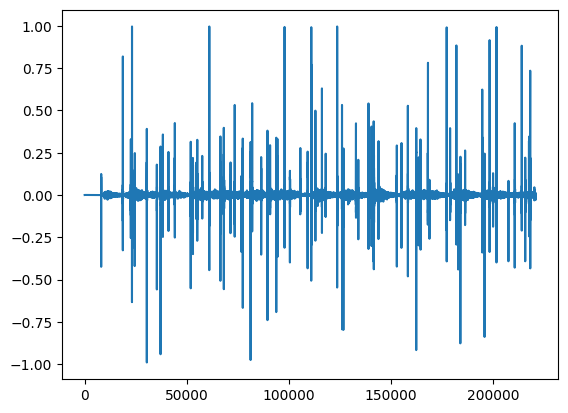

In [11]:
with torch.no_grad():
    snd2recon = model.decode(snd2_z) #z_from_l or z from encode are the same
snd2reconsignal = snd2recon[0,0,:].cpu().detach().numpy()
plt.plot(snd2reconsignal)
ipd.Audio(snd2reconsignal, rate=44100)

del  snd2recon
torch.cuda.empty_cache()

### <font color='blue'> Now look at the histogram of the values in the latent variables (choose one in the next cell by assigning it to examinevector).

In [12]:
# look at higher codebooks in the residual stack
#examinevector=snd2_latents[0,32:71,:] # [-6, 6]

# look at lower codebooks in the residual stack
#examinevector=snd2_latents[0,0:31,:]   # [-10, 10]

# look at all values in all codebooks
examinevector=snd2_latents[0,:,:]   # [-10, 10]

examinevector.shape

torch.Size([32, 431])

In [13]:
smallest_value = torch.min(examinevector)
largest_value = torch.max(examinevector)
print(f"The smallest value is {smallest_value.item()}")
print(f"The largest value is {largest_value.item()} ")

The smallest value is -16.329509735107422
The largest value is 20.031986236572266 


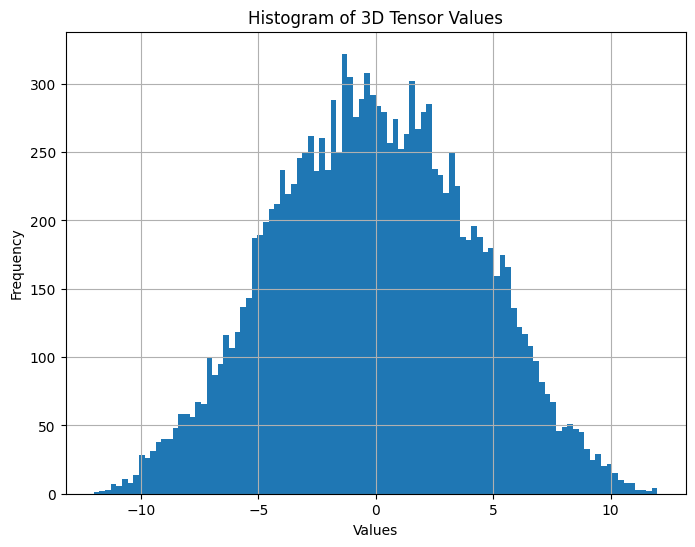

In [14]:
# Flatten the tensor to 1D
numpy_array = examinevector.cpu().detach().numpy().flatten()

# Define the number of bins
num_bins = 100

# Create a histogram using NumPy to compute bin edges and counts
hist, bins = np.histogram(numpy_array, bins=num_bins, range=(-12,12))


# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(bins[:-1], bins, weights=hist)
plt.title('Histogram of 3D Tensor Values')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Calculate positions for the labels spread across the horizontal width of the image
# label_positionsx = np.linspace(-num_bins/2, num_bins/2, num_bins)
# label_positionsy = linspace_v(0, np.max(hist), num_bins)

# #print(label_positions)
# # Annotate the plot with average values, rotating labels 90 degrees clockwise
# for i in range(num_bins):
#     label = f'{bin_avg_values[i]:.2f}'

plt.grid(True)
plt.show()

### <font color='blue'> Now clip the outliers and test sound quality.If it sounds good, we have our range for shifting into the PNG representation range.

norm of the projected latents is 502.117919921875
torch.max(modlatents) is 5.0
torch.max(z) is 12.25137996673584


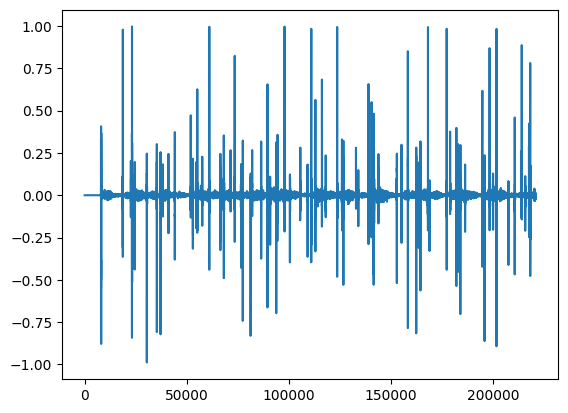

In [15]:
CLIPMIN=-5  # wow, sounds good even seriously clamping the values of the Gaussian tails!
CLIPMAX=5

#The norm is not exactly the same for all sounds, but roughly.
print(f'norm of the projected latents is {torch.norm(snd2_latents)}')

# Clamping does not degrade much (presumably because it doesn't change the angle very much)
modlatents = torch.clamp(snd2_latents, CLIPMIN, CLIPMAX)

###### Just some other random manipulation experiments 
### WOW - small effect 
#  modlatents = -modlatents
### also modest effect 
# modlatents=torch.flip(modlatents,[2])
## huge effect. Dimension matters
# modlatents=shuffledimrange(modlatents.cpu(),1, 0, 7).cuda()

print(f'torch.max(modlatents) is {torch.max(modlatents)}')

z,_a,_b = model.quantizer.from_latents(modlatents)
print(f'torch.max(z) is {torch.max(z)}')

del _a,_b
torch.cuda.empty_cache()

with torch.no_grad():
    snd = model.decode(z) #z_from_l or z from encode are the same

recon = snd[0,0,:].cpu().detach().numpy()
plt.plot(recon)
ipd.Audio(recon, rate=44100)

del z, snd
torch.cuda.empty_cache()


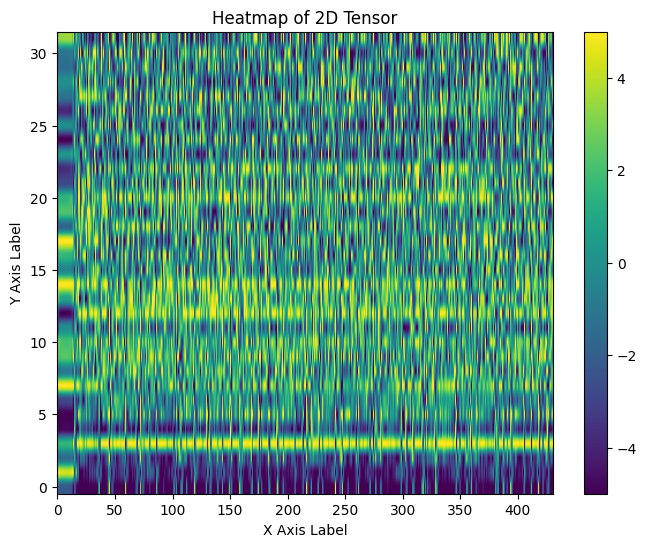

In [16]:
# Create a heatmap of the tensor just to see what it looks like
data=modlatents.cpu().detach().numpy()[0,:,:]
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.imshow(data, cmap='viridis', aspect='auto',origin='lower')  # 'viridis' colormap is used, 'aspect=auto' for aspect ratio

# Add colorbar for reference
plt.colorbar()

# Set labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Heatmap of 2D Tensor')

plt.show()

### <font color='blue'> Now create the gray-scale PNG. This means clipping, scaling, shifting, and descretizing to get the [0,255] we need. 

In [17]:
def crop_and_shift_to_uint8(tensor, minval, maxval):
    # Crop values between minval and maxval
    cropped_tensor = torch.clamp(tensor, minval, maxval)
    
    # Normalize the cropped tensor to range [0, 1]
    normalized_tensor = (cropped_tensor - minval) / (maxval - minval)
    
    # Scale values to range [0, 255] and convert to uint8
    uint8_tensor = (normalized_tensor * 255).to(torch.uint8)
    
    return uint8_tensor

def shift_uint8_to_float(image_uint8, minval, maxval):
    # Convert uint8 image tensor to float and scale it to [0, 1]
    normalized_image = image_uint8.float() / 255.0
    
    # Shift and scale the values to the desired range [minval, maxval]
    float_tensor = (normalized_image * (maxval - minval)) + minval
    
    return float_tensor

def display_uint8_image(image_uint8):
    # Convert uint8 tensor to a NumPy array
    image_np = image_uint8.numpy()

    # Display the image using Matplotlib
    plt.imshow(image_np, cmap='gray', vmin=0, vmax=255,origin='lower')  # Assuming grayscale image
    plt.axis('off')  # Hide axis
    plt.show()

In [18]:
pngdata = crop_and_shift_to_uint8(snd2_latents, CLIPMIN, CLIPMAX) 

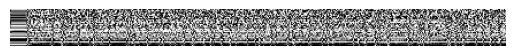

In [19]:
display_uint8_image(pngdata.cpu()[0,:,:])

### <font color='blue'> Now go from PNG to sound to see if the clipping and descretizing did any harm.

In [20]:
reconstructedlatents=shift_uint8_to_float(pngdata, CLIPMIN, CLIPMAX)

torch.max(z) is 12.25137996673584


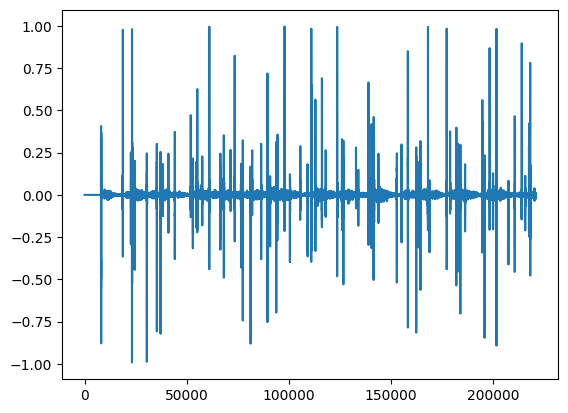

In [21]:
z,_a,_b = model.quantizer.from_latents(reconstructedlatents)
print(f'torch.max(z) is {torch.max(z)}')


with torch.no_grad():
    snd = model.decode(z) #z_from_l or z from encode are the same

recon = snd[0,0,:].cpu().detach().numpy()
plt.plot(recon)
ipd.Audio(recon, rate=44100)

In [22]:
del z, snd, snd2_latents, snd2_z, recon, _a, _b
torch.cuda.empty_cache()